In [1]:
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
#To set the seed for ensuring the generated result will be exactly same in every execution
import numpy as np
import random
import torch
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

In [3]:
import pandas as pd

#For reading the training dataset
sub_2 = pd.read_csv('train_sub_2.tsv', sep = '\t')

In [4]:
#View the dataset for the first five rows
sub_2.head(5)

,Unnamed: 0,id,text,label
0,0,6239,It was not until many years later that it coul...,0
1,1,9255,Users can then pin these images to their profi...,5
2,2,1674,The best songs are those that I can sing along...,1
3,3,5001,I found this book to be poorly written. It was...,3
4,4,20779,Regulates the application of the EU tariff quo...,4


In [5]:
from sklearn import preprocessing

#Transforming the 'label' variable, could easily process by machine
label_encoder = preprocessing.LabelEncoder()
sub_2['label'] = label_encoder.fit_transform(sub_2['label'])

In [6]:
from sklearn.model_selection import train_test_split 

#Splitting the data into train and test, and using the stratified methods to ensure the data is splitted distributed equally based on the dependent variable
train, test = train_test_split(sub_2, test_size=0.10, stratify=sub_2['label']) 
train, validation = train_test_split(train, test_size=0.10, stratify=train['label']) 

print(len(train), len(validation), len(test))

18156 2018 2242


In [7]:
train_text = list(train['text'])
train_label = list(train['label'])

val_text = list(validation['text'])
val_label = list(validation['label'])

In [8]:
#Set up the tokenizer from the BERT neural network
from transformers import BertTokenizer

#bert-base-uncased means it will treat upper case and lower case same as 'english' and 'English'
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [9]:
token_counts = []

#For finding the token length of the text after executing the process of tokenisation, then we could determine the maximum length of the tokenisation
for text in train_text:
  token_count = len(tokenizer.encode(text, max_length = 512, truncation = True))
  token_counts.append(token_count)


(0.0, 512.0)

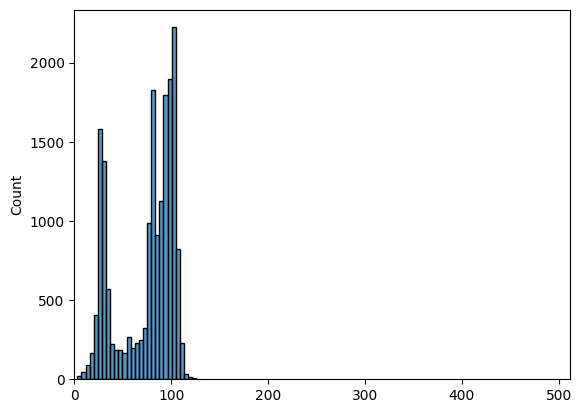

In [10]:
#For plotting the histogram of the token length of the texts after executing the process of tokenisation
from matplotlib import pyplot as plt
import seaborn as sns
sns.histplot(token_counts)
plt.xlim([0, 512])

Based on the result shown above, we could view the tokens' input_ids lengths are fallen within the range of (0, 128), which mean the input sentences's length are falling within these range. Therefore, we could set the maximum length for the tokenisation be 128, which could save more computation time and space.

# Translating Foreign Languages

###### Could uncomment it to run it (Due to it got poor performance compare to non-translating situation)

In [ ]:
"""
!pip install pyicu
!pip install pycld2
!pip install polyglot
!pip install morfessor
!pip install googletrans==4.0.0rc1

import chardet
from polyglot.detect import Detector

foreign_language = []

for length_of_sub_2 in range(len(sub_2)):
  text = sub_2['text'][length_of_sub_2]
  try:
    detector = Detector(text)
    if (detector.language.confidence < 98.0):
      foreign_language.append(length_of_sub_2)
  except:
    detect = chardet.detect(text.encode())
    if (detect['confidence'] < 0.90):
      foreign_language.append(length_of_sub_2)
    else:
      pass
"""

In [ ]:
"""
import nltk
import time
nltk.download("punkt")
from googletrans import Translator
from nltk.tokenize import WordPunctTokenizer

tk = WordPunctTokenizer()
translator = Translator()

for i in range (len(foreign_language) // 2):
  text = sub_2['text'][foreign_language[i]]
  translation = translator.translate(text, dest = 'en')
  text = translation.text
  time.sleep(0.5)
  sub_2['text'][foreign_language[i]] = text
"""

In [ ]:
"""
for i in range (len(foreign_language) // 2, len(foreign_language)):
  text = sub_2['text'][foreign_language[i]]
  translation = translator.translate(text, dest = 'en')
  text = translation.text
  time.sleep(0.5)
  sub_2['text'][foreign_language[i]] = text
""""

In [ ]:
"""
foreign_language = []

for length_of_sub_2 in range(len(sub_2)):
  text = sub_2['text'][length_of_sub_2]
  try:
    detector = Detector(text)
    if (detector.language.confidence < 98.0):
      foreign_language.append(length_of_sub_2)
  except:
    detect = chardet.detect(text.encode())
    if (detect['confidence'] < 0.90):
      foreign_language.append(length_of_sub_2)
    else:
      pass
"""

In [ ]:
"""
for i in range (len(foreign_language)//2):
  text = sub_2['text'][foreign_language[i]]
  tokens = tk.tokenize(text)
  for length_of_token in range (len(tokens)):
    translation = translator.translate(tokens[length_of_token], dest = 'en')
    tokens[length_of_token] = translation.text
    time.sleep(0.5)
  text = ' '.join(tokens)
  sub_2['text'][foreign_language[i]] = text
"""

In [ ]:
"""
for i in range (len(foreign_language)//2, len(foreign_language)):
  text = sub_2['text'][foreign_language[i]]
  tokens = tk.tokenize(text)
  for length_of_token in range (len(tokens)):
    translation = translator.translate(tokens[length_of_token], dest = 'en')
    tokens[length_of_token] = translation.text
    time.sleep(0.5)
  text = ' '.join(tokens)
  sub_2['text'][foreign_language[i]] = text
"""

# Searching Hyperparameter for BERT model

In [9]:
import emoji
from emot.emo_unicode import EMOTICONS_EMO
from transformers import BertForSequenceClassification

class TextPreprocessor:
    
    @classmethod
    def convert_emoticons(cls, text):
        for emot in EMOTICONS_EMO:
            text = text.replace(emot, EMOTICONS_EMO[emot].replace(" ","_"))
        return text

    @classmethod
    def preprocess_text(cls, texts):
        preprocessed_texts = []
        for text in texts:
            text = emoji.demojize(text)
            text = cls.convert_emoticons(text)
            preprocessed_texts.append(text)

        return preprocessed_texts

In [ ]:
# Preprocessing on those sentence (Could uncomment it for running it)
"""
import emoji
from nltk import pos_tag
from torch import nn, optim
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from emot.emo_unicode import EMOTICONS_EMO
from torch.utils.data import Dataset, DataLoader
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

class TextPreprocessor:
    tk = WordPunctTokenizer()
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    @classmethod
    def convert_emoticons(cls, text):
        for emot in EMOTICONS_EMO:
            text = text.replace(emot, EMOTICONS_EMO[emot].replace(" ","_"))
        return text

    @classmethod
    def get_wordnet_pos(cls, treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        elif treebank_tag.startswith('C'):
            return wordnet.NOUN
        elif treebank_tag.startswith('M'):
            return 'v'
        elif treebank_tag.startswith('I'):
            return wordnet.ADV
        else:
            return None

    @classmethod
    def preprocess_text(cls, texts):
        preprocessed_texts = []
        for text in texts:
            text = emoji.demojize(text)
            text = cls.convert_emoticons(text)
            tokens = cls.tk.tokenize(text)
            tokens = [token for token in tokens if token not in cls.stop_words]
            tokens = [token for token in tokens if token.isalnum()]
            tokens = [token for token in tokens if not isinstance(token, str) or not token.isnumeric()]
            pos_tags = pos_tag(tokens)
            lemmatized_tokens = [cls.lemmatizer.lemmatize(token, pos = cls.get_wordnet_pos(tag)) if cls.get_wordnet_pos(tag) is not None else token for token, tag in pos_tags]
            preprocessed_texts.append(lemmatized_tokens)

        return preprocessed_texts
""""

In [10]:
import datasets

#train_text = TextPreprocessor.preprocess_text(train_text)
#val_text = TextPreprocessor.preprocess_text(val_text)

train = pd.DataFrame({'text': train_text, 'label': train_label})
val = pd.DataFrame({'text': val_text, 'label': val_label})

train = datasets.Dataset.from_pandas(train)
val = datasets.Dataset.from_pandas(val)

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME) 

def preprocess(examples):   
# This will tokenize the text, add padding or truncate the text to the max length of 128     
    return tokenizer(examples['text'],truncation=True, padding='max_length',max_length=128)   

train = train.map(preprocess, batched=True)
val = val.map(preprocess, batched=True)

Map:   0%|          | 0/18156 [00:00<?, ? examples/s]

Map:   0%|          | 0/2018 [00:00<?, ? examples/s]

In [ ]:
import optuna
import torch
from transformers import Trainer, TrainingArguments

def objective(trial: optuna.Trial):
    # Define hyperparameters to optimize
    learning_rate = trial.suggest_loguniform("learning_rate", low=1e-6, high=1e-4)
    weight_decay = trial.suggest_loguniform("weight_decay", low=1e-6, high=1e-4)
    num_train_epochs = trial.suggest_categorical("num_train_epochs", [15, 18, 20])
    eval_steps = trial.suggest_int("eval_steps", low=10, high=1000)
    warmup_steps = trial.suggest_int("warmup_steps", low=10, high=1000)

    # Load BERT model and tokenizer
    model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels = 6)

    # Load train and validation datasets
    train_dataset = train
    val_dataset = val

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=256,
        per_device_eval_batch_size=256,
        warmup_steps=warmup_steps,
        logging_dir='./logs',
        logging_steps=5,
        evaluation_strategy='epoch',
        eval_steps=eval_steps,
        disable_tqdm=True
    )

    # Define trainer and train model
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset
    )

    trainer.train()

    # Return validation loss as the objective to minimize
    return trainer.evaluate(val_dataset)['eval_loss']

if __name__ == '__main__':
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=15)
    print(f"Best trial: {study.best_trial.params}")

[I 2023-05-06 11:13:47,286] A new study created in memory with name: no-name-92cc2196-127c-4531-a46e-7a29e9daf40a
/tmp/ipykernel_103616/2041105136.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform("learning_rate", low=1e-6, high=1e-4)
/tmp/ipykernel_103616/2041105136.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", low=1e-6, high=1e-4)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', '

{'loss': 1.8656, 'learning_rate': 1.654030791850368e-08, 'epoch': 0.06}
{'loss': 1.8445, 'learning_rate': 3.308061583700736e-08, 'epoch': 0.13}
{'loss': 1.8728, 'learning_rate': 4.962092375551104e-08, 'epoch': 0.19}
{'loss': 1.8582, 'learning_rate': 6.616123167401473e-08, 'epoch': 0.25}
{'loss': 1.8598, 'learning_rate': 8.27015395925184e-08, 'epoch': 0.32}
{'loss': 1.8511, 'learning_rate': 9.924184751102208e-08, 'epoch': 0.38}
{'loss': 1.8473, 'learning_rate': 1.1578215542952577e-07, 'epoch': 0.44}
{'loss': 1.8214, 'learning_rate': 1.3232246334802945e-07, 'epoch': 0.51}
{'loss': 1.8435, 'learning_rate': 1.4886277126653312e-07, 'epoch': 0.57}
{'loss': 1.8535, 'learning_rate': 1.654030791850368e-07, 'epoch': 0.63}
{'loss': 1.8575, 'learning_rate': 1.8194338710354046e-07, 'epoch': 0.7}
{'loss': 1.8505, 'learning_rate': 1.9848369502204416e-07, 'epoch': 0.76}
{'loss': 1.8484, 'learning_rate': 2.1502400294054783e-07, 'epoch': 0.82}
{'loss': 1.8262, 'learning_rate': 2.3156431085905153e-07, 'e

{'loss': 1.6135, 'learning_rate': 1.703651715605879e-06, 'epoch': 6.52}
{'loss': 1.6076, 'learning_rate': 1.7201920235243827e-06, 'epoch': 6.58}
{'loss': 1.5894, 'learning_rate': 1.7367323314428865e-06, 'epoch': 6.65}
{'loss': 1.5891, 'learning_rate': 1.7532726393613902e-06, 'epoch': 6.71}
{'loss': 1.5742, 'learning_rate': 1.7698129472798938e-06, 'epoch': 6.77}
{'loss': 1.5778, 'learning_rate': 1.7863532551983975e-06, 'epoch': 6.84}
{'loss': 1.5807, 'learning_rate': 1.8028935631169011e-06, 'epoch': 6.9}
{'loss': 1.5662, 'learning_rate': 1.819433871035405e-06, 'epoch': 6.96}
{'eval_loss': 1.5639469623565674, 'eval_runtime': 3.4794, 'eval_samples_per_second': 644.361, 'eval_steps_per_second': 2.587, 'epoch': 7.0}
{'loss': 1.5727, 'learning_rate': 1.8359741789539086e-06, 'epoch': 7.03}
{'loss': 1.5777, 'learning_rate': 1.8525144868724123e-06, 'epoch': 7.09}
{'loss': 1.5403, 'learning_rate': 1.869054794790916e-06, 'epoch': 7.15}
{'loss': 1.5417, 'learning_rate': 1.8855951027094195e-06, 'ep

{'loss': 1.1594, 'learning_rate': 1.671441642290898e-06, 'epoch': 12.97}
{'eval_loss': 1.196020483970642, 'eval_runtime': 3.4721, 'eval_samples_per_second': 645.717, 'eval_steps_per_second': 2.592, 'epoch': 13.0}
{'loss': 1.1623, 'learning_rate': 1.6192090909693077e-06, 'epoch': 13.04}
{'loss': 1.1136, 'learning_rate': 1.566976539647717e-06, 'epoch': 13.1}
{'loss': 1.1456, 'learning_rate': 1.5147439883261265e-06, 'epoch': 13.16}
{'loss': 1.1374, 'learning_rate': 1.462511437004536e-06, 'epoch': 13.23}
{'loss': 1.1348, 'learning_rate': 1.4102788856829453e-06, 'epoch': 13.29}
{'loss': 1.116, 'learning_rate': 1.3580463343613547e-06, 'epoch': 13.35}
{'loss': 1.1567, 'learning_rate': 1.3058137830397641e-06, 'epoch': 13.42}
{'loss': 1.1371, 'learning_rate': 1.2535812317181736e-06, 'epoch': 13.48}
{'loss': 1.1313, 'learning_rate': 1.201348680396583e-06, 'epoch': 13.54}
{'loss': 1.1349, 'learning_rate': 1.1491161290749924e-06, 'epoch': 13.61}
{'loss': 1.1258, 'learning_rate': 1.096883577753402e

[I 2023-05-06 11:36:52,675] Trial 0 finished with value: 1.1652449369430542 and parameters: {'learning_rate': 2.9772554253306624e-06, 'weight_decay': 1.0485738199546166e-05, 'num_train_epochs': 15, 'eval_steps': 329, 'warmup_steps': 900}. Best is trial 0 with value: 1.1652449369430542.


{'eval_loss': 1.1652449369430542, 'eval_runtime': 3.466, 'eval_samples_per_second': 646.85, 'eval_steps_per_second': 2.597, 'epoch': 15.0}


/tmp/ipykernel_103616/2041105136.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform("learning_rate", low=1e-6, high=1e-4)
/tmp/ipykernel_103616/2041105136.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", low=1e-6, high=1e-4)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transfor

{'loss': 1.8236, 'learning_rate': 2.933460510850224e-08, 'epoch': 0.06}
{'loss': 1.8081, 'learning_rate': 5.866921021700448e-08, 'epoch': 0.13}
{'loss': 1.8127, 'learning_rate': 8.800381532550672e-08, 'epoch': 0.19}
{'loss': 1.8117, 'learning_rate': 1.1733842043400897e-07, 'epoch': 0.25}
{'loss': 1.8112, 'learning_rate': 1.466730255425112e-07, 'epoch': 0.32}
{'loss': 1.8245, 'learning_rate': 1.7600763065101343e-07, 'epoch': 0.38}
{'loss': 1.8148, 'learning_rate': 2.0534223575951567e-07, 'epoch': 0.44}
{'loss': 1.8126, 'learning_rate': 2.3467684086801793e-07, 'epoch': 0.51}
{'loss': 1.8186, 'learning_rate': 2.6401144597652014e-07, 'epoch': 0.57}
{'loss': 1.8128, 'learning_rate': 2.933460510850224e-07, 'epoch': 0.63}
{'loss': 1.8191, 'learning_rate': 3.2268065619352466e-07, 'epoch': 0.7}
{'loss': 1.807, 'learning_rate': 3.5201526130202687e-07, 'epoch': 0.76}
{'loss': 1.8057, 'learning_rate': 3.8134986641052913e-07, 'epoch': 0.82}
{'loss': 1.8134, 'learning_rate': 4.1068447151903134e-07, 

{'loss': 1.4724, 'learning_rate': 2.0333651500049648e-06, 'epoch': 6.52}
{'loss': 1.4603, 'learning_rate': 2.0181907832138827e-06, 'epoch': 6.58}
{'loss': 1.4571, 'learning_rate': 2.0030164164228007e-06, 'epoch': 6.65}
{'loss': 1.4493, 'learning_rate': 1.9878420496317187e-06, 'epoch': 6.71}
{'loss': 1.4236, 'learning_rate': 1.972667682840637e-06, 'epoch': 6.77}
{'loss': 1.4236, 'learning_rate': 1.9574933160495554e-06, 'epoch': 6.84}
{'loss': 1.4266, 'learning_rate': 1.9423189492584734e-06, 'epoch': 6.9}
{'loss': 1.3885, 'learning_rate': 1.927144582467392e-06, 'epoch': 6.96}
{'eval_loss': 1.4189547300338745, 'eval_runtime': 3.4707, 'eval_samples_per_second': 645.979, 'eval_steps_per_second': 2.593, 'epoch': 7.0}
{'loss': 1.4245, 'learning_rate': 1.9119702156763098e-06, 'epoch': 7.03}
{'loss': 1.4123, 'learning_rate': 1.896795848885228e-06, 'epoch': 7.09}
{'loss': 1.3717, 'learning_rate': 1.8816214820941461e-06, 'epoch': 7.15}
{'loss': 1.3725, 'learning_rate': 1.8664471153030645e-06, 'ep

{'loss': 1.1317, 'learning_rate': 4.855797373146184e-07, 'epoch': 12.97}
{'eval_loss': 1.2093795537948608, 'eval_runtime': 3.4724, 'eval_samples_per_second': 645.662, 'eval_steps_per_second': 2.592, 'epoch': 13.0}
{'loss': 1.1462, 'learning_rate': 4.7040537052353653e-07, 'epoch': 13.04}
{'loss': 1.1106, 'learning_rate': 4.5523100373245477e-07, 'epoch': 13.1}
{'loss': 1.1183, 'learning_rate': 4.4005663694137295e-07, 'epoch': 13.16}
{'loss': 1.1188, 'learning_rate': 4.2488227015029107e-07, 'epoch': 13.23}
{'loss': 1.1494, 'learning_rate': 4.0970790335920925e-07, 'epoch': 13.29}
{'loss': 1.1075, 'learning_rate': 3.9453353656812743e-07, 'epoch': 13.35}
{'loss': 1.157, 'learning_rate': 3.793591697770456e-07, 'epoch': 13.42}
{'loss': 1.1349, 'learning_rate': 3.6418480298596374e-07, 'epoch': 13.48}
{'loss': 1.129, 'learning_rate': 3.4901043619488197e-07, 'epoch': 13.54}
{'loss': 1.1411, 'learning_rate': 3.3383606940380015e-07, 'epoch': 13.61}
{'loss': 1.1332, 'learning_rate': 3.18661702612718

[I 2023-05-06 11:59:58,080] Trial 1 finished with value: 1.194946050643921 and parameters: {'learning_rate': 2.370236092766981e-06, 'weight_decay': 3.167548004156325e-06, 'num_train_epochs': 15, 'eval_steps': 916, 'warmup_steps': 404}. Best is trial 0 with value: 1.1652449369430542.


{'eval_loss': 1.194946050643921, 'eval_runtime': 3.4729, 'eval_samples_per_second': 645.563, 'eval_steps_per_second': 2.591, 'epoch': 15.0}


/tmp/ipykernel_103616/2041105136.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform("learning_rate", low=1e-6, high=1e-4)
/tmp/ipykernel_103616/2041105136.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", low=1e-6, high=1e-4)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transfor

{'loss': 1.8236, 'learning_rate': 3.1296503914339525e-08, 'epoch': 0.06}
{'loss': 1.8081, 'learning_rate': 6.259300782867905e-08, 'epoch': 0.13}
{'loss': 1.8126, 'learning_rate': 9.388951174301857e-08, 'epoch': 0.19}
{'loss': 1.8117, 'learning_rate': 1.251860156573581e-07, 'epoch': 0.25}
{'loss': 1.8111, 'learning_rate': 1.5648251957169762e-07, 'epoch': 0.32}
{'loss': 1.8244, 'learning_rate': 1.8777902348603715e-07, 'epoch': 0.38}
{'loss': 1.8146, 'learning_rate': 2.1907552740037665e-07, 'epoch': 0.44}
{'loss': 1.8124, 'learning_rate': 2.503720313147162e-07, 'epoch': 0.51}
{'loss': 1.8184, 'learning_rate': 2.8166853522905575e-07, 'epoch': 0.57}
{'loss': 1.8125, 'learning_rate': 3.1296503914339525e-07, 'epoch': 0.63}
{'loss': 1.8188, 'learning_rate': 3.4426154305773474e-07, 'epoch': 0.7}
{'loss': 1.8066, 'learning_rate': 3.755580469720743e-07, 'epoch': 0.76}
{'loss': 1.8052, 'learning_rate': 4.068545508864138e-07, 'epoch': 0.82}
{'loss': 1.8128, 'learning_rate': 4.381510548007533e-07, '

{'loss': 1.3965, 'learning_rate': 3.223539903176971e-06, 'epoch': 6.52}
{'loss': 1.3836, 'learning_rate': 3.2548364070913103e-06, 'epoch': 6.58}
{'loss': 1.3817, 'learning_rate': 3.28613291100565e-06, 'epoch': 6.65}
{'loss': 1.3728, 'learning_rate': 3.31742941491999e-06, 'epoch': 6.71}
{'loss': 1.3483, 'learning_rate': 3.348725918834329e-06, 'epoch': 6.77}
{'loss': 1.3462, 'learning_rate': 3.3800224227486683e-06, 'epoch': 6.84}
{'loss': 1.3475, 'learning_rate': 3.411318926663008e-06, 'epoch': 6.9}
{'loss': 1.3069, 'learning_rate': 3.442615430577348e-06, 'epoch': 6.96}
{'eval_loss': 1.3541245460510254, 'eval_runtime': 3.4778, 'eval_samples_per_second': 644.658, 'eval_steps_per_second': 2.588, 'epoch': 7.0}
{'loss': 1.3472, 'learning_rate': 3.473911934491687e-06, 'epoch': 7.03}
{'loss': 1.3162, 'learning_rate': 3.5052084384060263e-06, 'epoch': 7.09}
{'loss': 1.2732, 'learning_rate': 3.5365049423203664e-06, 'epoch': 7.15}
{'loss': 1.282, 'learning_rate': 3.567801446234706e-06, 'epoch': 7.

{'loss': 0.9228, 'learning_rate': 2.3134935184052544e-06, 'epoch': 12.97}
{'eval_loss': 1.1188983917236328, 'eval_runtime': 3.4693, 'eval_samples_per_second': 646.24, 'eval_steps_per_second': 2.594, 'epoch': 13.0}
{'loss': 0.9462, 'learning_rate': 2.2411968459550903e-06, 'epoch': 13.04}
{'loss': 0.8921, 'learning_rate': 2.1689001735049263e-06, 'epoch': 13.1}
{'loss': 0.9043, 'learning_rate': 2.096603501054762e-06, 'epoch': 13.16}
{'loss': 0.892, 'learning_rate': 2.0243068286045978e-06, 'epoch': 13.23}
{'loss': 0.9197, 'learning_rate': 1.9520101561544337e-06, 'epoch': 13.29}
{'loss': 0.875, 'learning_rate': 1.8797134837042694e-06, 'epoch': 13.35}
{'loss': 0.9395, 'learning_rate': 1.8074168112541052e-06, 'epoch': 13.42}
{'loss': 0.9102, 'learning_rate': 1.735120138803941e-06, 'epoch': 13.48}
{'loss': 0.9087, 'learning_rate': 1.6628234663537768e-06, 'epoch': 13.54}
{'loss': 0.9132, 'learning_rate': 1.5905267939036126e-06, 'epoch': 13.61}
{'loss': 0.9139, 'learning_rate': 1.518230121453448

[I 2023-05-06 12:23:04,100] Trial 2 finished with value: 1.0825443267822266 and parameters: {'learning_rate': 5.176441747431757e-06, 'weight_decay': 1.3491514769839438e-06, 'num_train_epochs': 15, 'eval_steps': 828, 'warmup_steps': 827}. Best is trial 2 with value: 1.0825443267822266.


{'eval_loss': 1.0825443267822266, 'eval_runtime': 3.4681, 'eval_samples_per_second': 646.454, 'eval_steps_per_second': 2.595, 'epoch': 15.0}


/tmp/ipykernel_103616/2041105136.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform("learning_rate", low=1e-6, high=1e-4)
/tmp/ipykernel_103616/2041105136.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", low=1e-6, high=1e-4)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transfor

{'loss': 1.8235, 'learning_rate': 1.392437064683907e-07, 'epoch': 0.06}
{'loss': 1.8077, 'learning_rate': 2.784874129367814e-07, 'epoch': 0.13}
{'loss': 1.8114, 'learning_rate': 4.177311194051721e-07, 'epoch': 0.19}
{'loss': 1.8093, 'learning_rate': 5.569748258735628e-07, 'epoch': 0.25}
{'loss': 1.8073, 'learning_rate': 6.962185323419534e-07, 'epoch': 0.32}
{'loss': 1.8179, 'learning_rate': 8.354622388103441e-07, 'epoch': 0.38}
{'loss': 1.8069, 'learning_rate': 9.747059452787349e-07, 'epoch': 0.44}
{'loss': 1.8051, 'learning_rate': 1.1139496517471257e-06, 'epoch': 0.51}
{'loss': 1.8102, 'learning_rate': 1.2531933582155163e-06, 'epoch': 0.57}
{'loss': 1.8016, 'learning_rate': 1.3924370646839069e-06, 'epoch': 0.63}
{'loss': 1.8073, 'learning_rate': 1.5316807711522975e-06, 'epoch': 0.7}
{'loss': 1.7916, 'learning_rate': 1.6709244776206883e-06, 'epoch': 0.76}
{'loss': 1.7893, 'learning_rate': 1.8101681840890791e-06, 'epoch': 0.82}
{'loss': 1.7921, 'learning_rate': 1.9494118905574697e-06, '

{'loss': 0.9525, 'learning_rate': 1.4342101766244243e-05, 'epoch': 6.52}
{'loss': 0.9157, 'learning_rate': 1.4481345472712633e-05, 'epoch': 6.58}
{'loss': 0.9061, 'learning_rate': 1.4620589179181023e-05, 'epoch': 6.65}
{'loss': 0.9202, 'learning_rate': 1.4759832885649415e-05, 'epoch': 6.71}
{'loss': 0.9202, 'learning_rate': 1.4899076592117804e-05, 'epoch': 6.77}
{'loss': 0.9045, 'learning_rate': 1.5038320298586196e-05, 'epoch': 6.84}
{'loss': 0.9655, 'learning_rate': 1.5177564005054586e-05, 'epoch': 6.9}
{'loss': 0.9061, 'learning_rate': 1.5316807711522974e-05, 'epoch': 6.96}
{'eval_loss': 1.0931090116500854, 'eval_runtime': 3.4716, 'eval_samples_per_second': 645.806, 'eval_steps_per_second': 2.592, 'epoch': 7.0}
{'loss': 0.9237, 'learning_rate': 1.5456051417991368e-05, 'epoch': 7.03}
{'loss': 0.8866, 'learning_rate': 1.5595295124459758e-05, 'epoch': 7.09}
{'loss': 0.876, 'learning_rate': 1.5734538830928148e-05, 'epoch': 7.15}
{'loss': 0.8695, 'learning_rate': 1.5873782537396538e-05, '

{'loss': 0.5463, 'learning_rate': 1.302324877408428e-05, 'epoch': 12.91}
{'loss': 0.5297, 'learning_rate': 1.2906969767172815e-05, 'epoch': 12.97}
{'eval_loss': 1.1631795167922974, 'eval_runtime': 3.4735, 'eval_samples_per_second': 645.457, 'eval_steps_per_second': 2.591, 'epoch': 13.0}
{'loss': 0.5349, 'learning_rate': 1.2790690760261346e-05, 'epoch': 13.04}
{'loss': 0.5112, 'learning_rate': 1.267441175334988e-05, 'epoch': 13.1}
{'loss': 0.5211, 'learning_rate': 1.2558132746438413e-05, 'epoch': 13.16}
{'loss': 0.4813, 'learning_rate': 1.2441853739526946e-05, 'epoch': 13.23}
{'loss': 0.5165, 'learning_rate': 1.232557473261548e-05, 'epoch': 13.29}
{'loss': 0.4921, 'learning_rate': 1.2209295725704014e-05, 'epoch': 13.35}
{'loss': 0.5101, 'learning_rate': 1.2093016718792547e-05, 'epoch': 13.42}
{'loss': 0.4926, 'learning_rate': 1.197673771188108e-05, 'epoch': 13.48}
{'loss': 0.5218, 'learning_rate': 1.1860458704969612e-05, 'epoch': 13.54}
{'loss': 0.4868, 'learning_rate': 1.17441796980581

{'loss': 0.3412, 'learning_rate': 1.5116270898490683e-06, 'epoch': 19.18}
{'loss': 0.3279, 'learning_rate': 1.3953480829376015e-06, 'epoch': 19.24}
{'loss': 0.3463, 'learning_rate': 1.2790690760261348e-06, 'epoch': 19.3}
{'loss': 0.3499, 'learning_rate': 1.162790069114668e-06, 'epoch': 19.37}
{'loss': 0.3514, 'learning_rate': 1.0465110622032013e-06, 'epoch': 19.43}
{'loss': 0.328, 'learning_rate': 9.302320552917344e-07, 'epoch': 19.49}
{'loss': 0.3673, 'learning_rate': 8.139530483802675e-07, 'epoch': 19.56}
{'loss': 0.3206, 'learning_rate': 6.976740414688007e-07, 'epoch': 19.62}
{'loss': 0.3244, 'learning_rate': 5.81395034557334e-07, 'epoch': 19.68}
{'loss': 0.3361, 'learning_rate': 4.651160276458672e-07, 'epoch': 19.75}
{'loss': 0.3426, 'learning_rate': 3.4883702073440036e-07, 'epoch': 19.81}
{'loss': 0.3648, 'learning_rate': 2.325580138229336e-07, 'epoch': 19.87}
{'loss': 0.3278, 'learning_rate': 1.162790069114668e-07, 'epoch': 19.94}
{'loss': 0.351, 'learning_rate': 0.0, 'epoch': 20

[I 2023-05-06 12:53:52,069] Trial 3 finished with value: 1.4439458847045898 and parameters: {'learning_rate': 2.0023244990154582e-05, 'weight_decay': 1.1078244049305734e-05, 'num_train_epochs': 20, 'eval_steps': 397, 'warmup_steps': 719}. Best is trial 2 with value: 1.0825443267822266.


{'eval_loss': 1.4439458847045898, 'eval_runtime': 3.4709, 'eval_samples_per_second': 645.937, 'eval_steps_per_second': 2.593, 'epoch': 20.0}


/tmp/ipykernel_103616/2041105136.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform("learning_rate", low=1e-6, high=1e-4)
/tmp/ipykernel_103616/2041105136.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", low=1e-6, high=1e-4)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transfor

{'loss': 1.8466, 'learning_rate': 9.155602676790721e-08, 'epoch': 0.06}
{'loss': 1.8404, 'learning_rate': 1.8311205353581442e-07, 'epoch': 0.13}
{'loss': 1.8385, 'learning_rate': 2.7466808030372164e-07, 'epoch': 0.19}
{'loss': 1.845, 'learning_rate': 3.6622410707162884e-07, 'epoch': 0.25}
{'loss': 1.8392, 'learning_rate': 4.577801338395361e-07, 'epoch': 0.32}
{'loss': 1.8532, 'learning_rate': 5.493361606074433e-07, 'epoch': 0.38}
{'loss': 1.8231, 'learning_rate': 6.408921873753505e-07, 'epoch': 0.44}
{'loss': 1.8403, 'learning_rate': 7.324482141432577e-07, 'epoch': 0.51}
{'loss': 1.8291, 'learning_rate': 8.24004240911165e-07, 'epoch': 0.57}
{'loss': 1.8401, 'learning_rate': 9.155602676790722e-07, 'epoch': 0.63}
{'loss': 1.8305, 'learning_rate': 1.0071162944469794e-06, 'epoch': 0.7}
{'loss': 1.8303, 'learning_rate': 1.0986723212148866e-06, 'epoch': 0.76}
{'loss': 1.8099, 'learning_rate': 1.1902283479827938e-06, 'epoch': 0.82}
{'loss': 1.8193, 'learning_rate': 1.281784374750701e-06, 'epo

{'loss': 0.9938, 'learning_rate': 8.6740112685903e-06, 'epoch': 6.58}
{'loss': 1.0202, 'learning_rate': 8.63309612109695e-06, 'epoch': 6.65}
{'loss': 0.9922, 'learning_rate': 8.5921809736036e-06, 'epoch': 6.71}
{'loss': 1.0043, 'learning_rate': 8.551265826110249e-06, 'epoch': 6.77}
{'loss': 0.9846, 'learning_rate': 8.510350678616899e-06, 'epoch': 6.84}
{'loss': 1.0083, 'learning_rate': 8.469435531123547e-06, 'epoch': 6.9}
{'loss': 0.9704, 'learning_rate': 8.428520383630197e-06, 'epoch': 6.96}
{'eval_loss': 1.1382741928100586, 'eval_runtime': 3.4787, 'eval_samples_per_second': 644.5, 'eval_steps_per_second': 2.587, 'epoch': 7.0}
{'loss': 1.0097, 'learning_rate': 8.387605236136847e-06, 'epoch': 7.03}
{'loss': 0.9845, 'learning_rate': 8.346690088643497e-06, 'epoch': 7.09}
{'loss': 0.9542, 'learning_rate': 8.305774941150147e-06, 'epoch': 7.15}
{'loss': 0.9334, 'learning_rate': 8.264859793656796e-06, 'epoch': 7.22}
{'loss': 0.9569, 'learning_rate': 8.223944646163446e-06, 'epoch': 7.28}
{'lo

In [15]:
print(f"Best trial: {study.best_trial.params}")

Best trial: {'learning_rate': 5.743251747122259e-06, 'weight_decay': 5.586384316928891e-06, 'num_train_epochs': 20, 'eval_steps': 985, 'warmup_steps': 779}


# Fine-Tune Bert Model

In [11]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


#This class is used to execute the preprocessing purpose
class TextDataset(Dataset):

    def __init__(self, text, labels, tokenizer, max_len):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def convert_emoticons(self, text):
      for emot in EMOTICONS_EMO:
          text = text.replace(emot, EMOTICONS_EMO[emot].replace(" ","_"))
      return text

    #For tokenize the sentence by using encode_plus() function, it could generate the input_ids and attention_mask which are needed to fit into BERT pre-trained model for fine-tuning.
    #In addition, encode_plus() is more flexible than encode() as able to setting more parameters
    def __getitem__(self, item):
      text = str(self.text[item])
      label = self.labels[item]
      #text = [emoji.demojize(sentences) for sentences in text]
      #text = [self.convert_emoticons(sentences) for sentences in text]
      encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        truncation=True,
        padding='max_length',
        return_token_type_ids=False, #Segmentation embedding
        return_attention_mask=True,
        return_tensors='pt',
      )

    #After executing this preprocessing class, it will return the original text, input_ids, attention_mask, and the label of the text
      return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': torch.tensor(label, dtype=torch.long)
      }


In [ ]:
# Scenario for preprocessing 
"""
import emoji
from nltk import pos_tag
from torch import nn, optim
from nltk.stem import WordNetLemmatizer
from emot.emo_unicode import EMOTICONS_EMO
from nltk.corpus import stopwords, wordnet
from torch.utils.data import Dataset, DataLoader
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


#This class is used to execute the preprocessing purpose
class TextDataset(Dataset):

    tk = WordPunctTokenizer()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()


    def __init__(self, text, labels, tokenizer, max_len):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def convert_emoticons(self, text):
      for emot in EMOTICONS_EMO:
          text = text.replace(emot, EMOTICONS_EMO[emot].replace(" ","_"))
      return text

    def get_wordnet_pos(self, treebank_tag):
      if treebank_tag.startswith('J'): # Adjective (JJ)
          return wordnet.ADJ
      elif treebank_tag.startswith('V'): # Verb (VB)
          return wordnet.VERB
      elif treebank_tag.startswith('N'): # Noun (NN)
          return wordnet.NOUN
      elif treebank_tag.startswith('R'): # Adverb (RB) 
          return wordnet.ADV
      elif treebank_tag.startswith('C'): # Conjunction (CC)
          return wordnet.NOUN
      elif treebank_tag.startswith('M'):
          return 'v'
      elif treebank_tag.startswith('I'): # Preposition (IN)
          return wordnet.ADV
      else:
          return None

    #For tokenize the sentence by using encode_plus() function, it could generate the input_ids and attention_mask which are needed to fit into BERT pre-trained model for fine-tuning.
    #In addition, encode_plus() is more flexible than encode() as able to setting more parameters
    def __getitem__(self, item):
        text = str(self.text[item])
        label = self.labels[item]
        text = [emoji.demojize(sentences) for sentences in text]
        text = [self.convert_emoticons(sentences) for sentences in text]
        text = [self.tk.tokenize(sentences) for sentences in text]
        text = [[token for token in sentence if token not in self.stop_words] for sentence in text]
        text = [[token for token in sentence if token.isalnum()] for sentence in text]
        text = [[token for token in sentence if not isinstance(token, str) or not token.isnumeric()] for sentence in text]
        text = [pos_tag(sentence) for sentence in text]
        text = [[self.lemmatizer.lemmatize(token, pos=get_wordnet_pos(tag)) if get_wordnet_pos(tag) is not None else token for token, tag in sentence] for sentence in text]        
        text = [' '.join(sentence) for sentence in text]
        text = ' '.join(text)
        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          truncation=True,
          padding='max_length',
          return_token_type_ids=False, #Segmentation embedding
          return_attention_mask=True,
          return_tensors='pt',
        )

        #After executing this preprocessing class, it will return the input_ids, attention_mask, and the label of the text
        return {
          #'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(label, dtype=torch.long)
        }
"""

In [12]:
#For executing the Neural Network, the input data should be using the DataLoader() function to split them into multiple batches
def create_data_loader(X, Y, tokenizer, max_len, batch_size, num_workers=2, sampler = None):
    ds = TextDataset(
    text = np.array(X),
    labels = np.array(Y),
    tokenizer = tokenizer,
    max_len = max_len
  )
    if sampler != None:
        sampler = sampler(ds)

    return DataLoader(
        ds,
        batch_size = batch_size,
        num_workers = num_workers,
        sampler = sampler,
  )

In [13]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

MAX_LEN = 128

#Since the input data is too large that consisted by 33845 rows of sentences then we could set the batch size with small value as 16
BATCH_SIZE = 256

train_data_loader = create_data_loader(train_text, train_label, tokenizer=tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE, sampler=RandomSampler)
val_data_loader = create_data_loader(val_text, val_label, tokenizer=tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE, sampler=SequentialSampler)

In [14]:
#Setting up the BERT model configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    num_labels = 6,  
    output_attentions = False,
    output_hidden_states = False,)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [15]:
from torch.optim import AdamW

#Executing Stochastic Gradient Descent for adjusting the weight based on the error that calculated by using the actual label and predicted label
#The learning rate for Stochastic Gradient Descent is 0.000001
optimizer = AdamW(model.parameters(), lr = 5.743251747122259e-06, weight_decay = 5.586384316928891e-06,)

In [16]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4 (depend on the usage, you can also set it larger)
# We chose to run for 1 epoch first
EPOCHS = 20

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_data_loader) * EPOCHS

# Create the learning rate scheduler, here we use a linear scheduler with no warmup steps
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 779,
                                            num_training_steps = total_steps)

# Define our loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [17]:
# Training
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()
    total_train_accuracy = 0
    total_train_loss = 0
    losses = []
    correct_predictions = 0
    for step, batch in enumerate(data_loader):
        if step % 40 == 0 and not step == 0:
            print('Batch: {}  of  {}'.format(step, len(data_loader)))
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        model.zero_grad()
        outputs = model(
          input_ids=input_ids,
          token_type_ids=None,
          attention_mask=attention_mask,
          labels=labels
        )
        loss = outputs[0]
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        logits = outputs[1].detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        total_train_accuracy += flat_accuracy(logits, label_ids)
  # Calculate the average loss over all of the batches.
    avg_train_accuracy = total_train_accuracy / len(data_loader)
    avg_train_loss = total_train_loss / len(data_loader) 
    return avg_train_accuracy, avg_train_loss

In [18]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [19]:
# Evaluation
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 985
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(
            input_ids=input_ids,
            token_type_ids=None,
            attention_mask=attention_mask,
            labels=labels
            )
            total_eval_loss += outputs[0].item()
            logits = outputs[1].detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(data_loader)
    avg_val_loss = total_eval_loss / len(data_loader)
    return avg_val_accuracy, avg_val_loss

In [20]:
%%time
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print('Epoch: {}/{}'.format(epoch+1, EPOCHS))
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_text)
    )
    print('Train loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(val_text)
    )
    print('Validation loss: {}, Accuracy: {}'.format(val_loss, val_acc))
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['validation_acc'].append(val_acc)
    history['validation_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch: 1/20
----------
Batch: 40  of  71
Train loss: 1.8418347079988937, Accuracy: 0.17490469831702077
Validation loss: 1.8218490332365036, Accuracy: 0.17752696349557523

Epoch: 2/20
----------
Batch: 40  of  71
Train loss: 1.7925179105409434, Accuracy: 0.19856226873955599
Validation loss: 1.7626065164804459, Accuracy: 0.2119659153761062

Epoch: 3/20
----------
Batch: 40  of  71
Train loss: 1.752777010622159, Accuracy: 0.23905149647887325
Validation loss: 1.7223335653543472, Accuracy: 0.25063519773230086

Epoch: 4/20
----------
Batch: 40  of  71
Train loss: 1.7053040215666866, Accuracy: 0.28394772767963716
Validation loss: 1.6595298647880554, Accuracy: 0.3374455544800885

Epoch: 5/20
----------
Batch: 40  of  71
Train loss: 1.6359185769524374, Accuracy: 0.33085443274051085
Validation loss: 1.579737901687622, Accuracy: 0.3652775857300885

Epoch: 6/20
----------
Batch: 40  of  71
Train loss: 1.534264452020887, Accuracy: 0.3693910017307233
Validation loss: 1.470609501004219, Accuracy: 0.4

In [21]:
model.save_pretrained('bert model (subtask 2)')

In [22]:
model = BertForSequenceClassification.from_pretrained('bert model (subtask 2)')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [23]:
extract_label = test.copy()

extract_label.drop(['text'], axis = 1, inplace = True)
extract_label.loc[extract_label['label'] == 0, 'label'] = 'A'
extract_label.loc[extract_label['label'] == 1, 'label'] = 'B'
extract_label.loc[extract_label['label'] == 2, 'label'] = 'C'
extract_label.loc[extract_label['label'] == 3, 'label'] = 'D'
extract_label.loc[extract_label['label'] == 4, 'label'] = 'E'
extract_label.loc[extract_label['label'] == 5, 'label'] = 'F'
extract_label.set_index('id', inplace = True)
extract_label.to_csv('AuTexTificationEval/task_submissions/ground_truth/subtask_2/en/truth.tsv', sep="\t")

In [24]:
bert_test = test.copy()

# Tokenize test data
test_inputs = tokenizer(
    bert_test["text"].tolist(),
    add_special_tokens=True,
    max_length=128,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    return_tensors="pt"
)

batch_size = 256
num_samples = len(test_inputs["input_ids"])
test_preds = []

# iterate through batches and make predictions
for i in range(0, num_samples, batch_size):
    batch_inputs = {
        "input_ids": test_inputs["input_ids"][i:i+batch_size].to(device),
        "attention_mask": test_inputs["attention_mask"][i:i+batch_size].to(device)
    }
    with torch.no_grad():
        batch_outputs = model(batch_inputs["input_ids"], batch_inputs["attention_mask"])
        batch_preds = torch.argmax(batch_outputs.logits, dim=1)
        test_preds.extend(batch_preds.cpu().tolist())

# concatenate predictions from all batches
bert_test["label"] = test_preds

In [25]:
bert_test.drop(['text'], axis = 1, inplace = True)
bert_test.loc[bert_test['label'] == 0, 'label'] = 'A'
bert_test.loc[bert_test['label'] == 1, 'label'] = 'B'
bert_test.loc[bert_test['label'] == 2, 'label'] = 'C'
bert_test.loc[bert_test['label'] == 3, 'label'] = 'D'
bert_test.loc[bert_test['label'] == 4, 'label'] = 'E'
bert_test.loc[bert_test['label'] == 5, 'label'] = 'F'
bert_test.set_index('id', inplace = True)
bert_test.to_csv('AuTexTificationEval/task_submissions/submissions/my_team/subtask_2/en/pred (bert subtask 2).tsv', sep="\t")

In [26]:
sub_2_test = pd.read_csv('test_sub_2.tsv', sep = '\t')
display(sub_2_test.head(5))

,id,text
0,1099,Love it! It cooks anything from broccoli to me...
1,1950,I would like to know more about the background...
2,936,It has a very good texture and looks like it w...
3,6198,"We dont know for sure if they will win it all,..."
4,14765,This is a decision that your friend will have ...


In [27]:
# Tokenize test data
test_inputs = tokenizer(
    sub_2_test["text"].tolist(),
    add_special_tokens=True,
    max_length=128,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    return_tensors="pt"
)

batch_size = 256
num_samples = len(test_inputs["input_ids"])
test_preds = []

# iterate through batches and make predictions
for i in range(0, num_samples, batch_size):
    batch_inputs = {
        "input_ids": test_inputs["input_ids"][i:i+batch_size].to(device),
        "attention_mask": test_inputs["attention_mask"][i:i+batch_size].to(device)
    }
    with torch.no_grad():
        batch_outputs = model(batch_inputs["input_ids"], batch_inputs["attention_mask"])
        batch_preds = torch.argmax(batch_outputs.logits, dim=1)
        test_preds.extend(batch_preds.cpu().tolist())

# concatenate predictions from all batches
sub_2_test["label"] = test_preds

In [28]:
sub_2_test.drop(['text'], axis = 1, inplace = True)
sub_2_test.loc[sub_2_test['label'] == 0, 'label'] = 'A'
sub_2_test.loc[sub_2_test['label'] == 1, 'label'] = 'B'
sub_2_test.loc[sub_2_test['label'] == 2, 'label'] = 'C'
sub_2_test.loc[sub_2_test['label'] == 3, 'label'] = 'D'
sub_2_test.loc[sub_2_test['label'] == 4, 'label'] = 'E'
sub_2_test.loc[sub_2_test['label'] == 5, 'label'] = 'F'
sub_2_test.set_index('id', inplace = True)
sub_2_test.to_csv('AuTexTificationEval/task_submissions/submissions/my_team/subtask_2/en/run1 (subtask 2).tsv', sep="\t")

# Searching Hyperparameter for XLM-R Model

In [29]:
# Import necessary libraries
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW

PRE_TRAINED_MODEL_NAME = 'xlm-roberta-base'

train = pd.DataFrame({'text': train_text, 'label': train_label})
val = pd.DataFrame({'text': val_text, 'label': val_label})

train = datasets.Dataset.from_pandas(train)
val = datasets.Dataset.from_pandas(val)

tokenizer = XLMRobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME) 

def preprocess(examples):   
# This will tokenize the text, add padding or truncate the text to the max length of 128     
    return tokenizer(examples['text'],truncation=True,   padding='max_length',max_length=128)   

train = train.map(preprocess, batched=True)
val = val.map(preprocess, batched=True)

Map:   0%|          | 0/18156 [00:00<?, ? examples/s]

Map:   0%|          | 0/2018 [00:00<?, ? examples/s]

In [ ]:
import optuna
import torch
from transformers import Trainer, TrainingArguments

def objective(trial: optuna.Trial):
    # Define hyperparameters to optimize
    learning_rate = trial.suggest_loguniform("learning_rate", low=1e-6, high=1e-4)
    weight_decay = trial.suggest_loguniform("weight_decay", low=1e-6, high=1e-4)
    num_train_epochs = trial.suggest_categorical("num_train_epochs", [15, 18, 21])
    eval_steps = trial.suggest_int("eval_steps", low=10, high=1000)
    warmup_steps = trial.suggest_int("warmup_steps", low=10, high=1000)
    
    # Load BERT model and tokenizer
    model = XLMRobertaForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels = 6)

    # Load train and validation datasets
    train_dataset = train
    val_dataset = val

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=256,
        per_device_eval_batch_size=256,
        warmup_steps=warmup_steps,
        logging_dir='./logs',
        logging_steps=5,
        evaluation_strategy='epoch',
        eval_steps=eval_steps,
        disable_tqdm=True
    )
    
    # Define trainer and train model
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset
    )

    trainer.train()

    # Return validation loss as the objective to minimize
    return trainer.evaluate(val_dataset)['eval_loss']

if __name__ == '__main__':
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=15)
    print(f"Best trial: {study.best_trial.params}")


In [36]:
print(f"Best trial: {study.best_trial.params}")

Best trial: {'learning_rate': 8.392416726908706e-06, 'weight_decay': 9.254647643242819e-06, 'num_train_epochs': 15, 'eval_steps': 730, 'warmup_steps': 330}


# XLM-Roberta Model

In [30]:
# Load pre-trained XLM-RoBERTa model and tokenizer
model = XLMRobertaForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=6)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [31]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

MAX_LEN = 128

#Since the input data is too large that consisted by 33845 rows of sentences then we could set the batch size with small value as 16
BATCH_SIZE = 256

train_data_loader = create_data_loader(train_text, train_label, tokenizer=tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE, sampler=RandomSampler)
val_data_loader = create_data_loader(val_text, val_label, tokenizer=tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE, sampler=SequentialSampler)

In [32]:
from torch.optim import AdamW

#Executing Stochastic Gradient Descent for adjusting the weight based on the error that calculated by using the actual label and predicted label
#The learning rate for Stochastic Gradient Descent is 1.5793779201582996e-05
optimizer = AdamW(model.parameters(), lr = 8.392416726908706e-06, weight_decay = 9.254647643242819e-06,)

from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4 (depend on the usage, you can also set it larger)
# We chose to run for 1 epoch first
EPOCHS = 15

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_data_loader) * EPOCHS

# Create the learning rate scheduler, here we use a linear scheduler with no warmup steps
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 330,
                                            num_training_steps = total_steps)

# Define our loss function
loss_fn = nn.CrossEntropyLoss().to(device)

# Evaluation
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 730
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(
            input_ids=input_ids,
            token_type_ids=None,
            attention_mask=attention_mask,
            labels=labels
            )
            total_eval_loss += outputs[0].item()
            logits = outputs[1].detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(data_loader)
    avg_val_loss = total_eval_loss / len(data_loader)
    #print("Accuracy: {0:.2f}".format(avg_val_accuracy))
    #print("Validation Loss: {0:.2f}".format(avg_val_loss))
    return avg_val_accuracy, avg_val_loss

In [33]:
%%time
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_fn.to(device)


for epoch in range(EPOCHS):
    print('Epoch: {}/{}'.format(epoch+1, EPOCHS))
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_text)
    )
    print('Train loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(val_text)
    )
    print('Validation loss: {}, Accuracy: {}'.format(val_loss, val_acc))
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch: 1/15
----------
Batch: 40  of  71
Train loss: 1.8102380843229697, Accuracy: 0.16811888278825496
Test loss: 1.8012012243270874, Accuracy: 0.1680206028761062

Epoch: 2/15
----------
Batch: 40  of  71
Train loss: 1.7749992525073843, Accuracy: 0.19403310754356648
Test loss: 1.683886557817459, Accuracy: 0.29425210868362833

Epoch: 3/15
----------
Batch: 40  of  71
Train loss: 1.6565239211203346, Accuracy: 0.26111075883265694
Test loss: 1.5396881699562073, Accuracy: 0.3354924294800885

Epoch: 4/15
----------
Batch: 40  of  71
Train loss: 1.5201821125728983, Accuracy: 0.33781555860587253
Test loss: 1.3691502809524536, Accuracy: 0.4159551299778761

Epoch: 5/15
----------
Batch: 40  of  71
Train loss: 1.2759727961580518, Accuracy: 0.43906380550250657
Test loss: 1.1684436202049255, Accuracy: 0.48675159015486724

Epoch: 6/15
----------
Batch: 40  of  71
Train loss: 1.11255758916828, Accuracy: 0.5055744957030317
Test loss: 1.09280164539814, Accuracy: 0.5197256982853983

Epoch: 7/15
--------

In [34]:
model.save_pretrained('xlm-r model (subtask 2)')

In [35]:
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-r model (subtask 2)')
model.to(device)

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [36]:
xlm_test = test.copy()

# Tokenize test data
test_inputs = tokenizer(
    xlm_test["text"].tolist(),
    add_special_tokens=True,
    max_length=128,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    return_tensors="pt"
)

batch_size = 256
num_samples = len(test_inputs["input_ids"])
test_preds = []

# iterate through batches and make predictions
for i in range(0, num_samples, batch_size):
    batch_inputs = {
        "input_ids": test_inputs["input_ids"][i:i+batch_size].to(device),
        "attention_mask": test_inputs["attention_mask"][i:i+batch_size].to(device)
    }
    with torch.no_grad():
        batch_outputs = model(batch_inputs["input_ids"], batch_inputs["attention_mask"])
        batch_preds = torch.argmax(batch_outputs.logits, dim=1)
        test_preds.extend(batch_preds.cpu().tolist())

# concatenate predictions from all batches
xlm_test["label"] = test_preds

In [37]:
xlm_test.drop(['text'], axis = 1, inplace = True)
xlm_test.loc[xlm_test['label'] == 0, 'label'] = 'A'
xlm_test.loc[xlm_test['label'] == 1, 'label'] = 'B'
xlm_test.loc[xlm_test['label'] == 2, 'label'] = 'C'
xlm_test.loc[xlm_test['label'] == 3, 'label'] = 'D'
xlm_test.loc[xlm_test['label'] == 4, 'label'] = 'E'
xlm_test.loc[xlm_test['label'] == 5, 'label'] = 'F'
xlm_test.set_index('id', inplace = True)
xlm_test.to_csv('AuTexTificationEval/task_submissions/submissions/my_team/subtask_2/en/pred (xlm-r subtask 2).tsv', sep="\t")

In [38]:
sub_2_test = pd.read_csv('test_sub_2.tsv', sep = '\t')
display(sub_2_test.head(5))

,id,text
0,1099,Love it! It cooks anything from broccoli to me...
1,1950,I would like to know more about the background...
2,936,It has a very good texture and looks like it w...
3,6198,"We dont know for sure if they will win it all,..."
4,14765,This is a decision that your friend will have ...


In [39]:
# Tokenize test data
test_inputs = tokenizer(
    sub_2_test["text"].tolist(),
    add_special_tokens=True,
    max_length=128,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    return_tensors="pt"
)

batch_size = 256
num_samples = len(test_inputs["input_ids"])
test_preds = []

# iterate through batches and make predictions
for i in range(0, num_samples, batch_size):
    batch_inputs = {
        "input_ids": test_inputs["input_ids"][i:i+batch_size].to(device),
        "attention_mask": test_inputs["attention_mask"][i:i+batch_size].to(device)
    }
    with torch.no_grad():
        batch_outputs = model(batch_inputs["input_ids"], batch_inputs["attention_mask"])
        batch_preds = torch.argmax(batch_outputs.logits, dim=1)
        test_preds.extend(batch_preds.cpu().tolist())

# concatenate predictions from all batches
sub_2_test["label"] = test_preds

In [40]:
sub_2_test.drop(['text'], axis = 1, inplace = True)
sub_2_test.loc[sub_2_test['label'] == 0, 'label'] = 'A'
sub_2_test.loc[sub_2_test['label'] == 1, 'label'] = 'B'
sub_2_test.loc[sub_2_test['label'] == 2, 'label'] = 'C'
sub_2_test.loc[sub_2_test['label'] == 3, 'label'] = 'D'
sub_2_test.loc[sub_2_test['label'] == 4, 'label'] = 'E'
sub_2_test.loc[sub_2_test['label'] == 5, 'label'] = 'F'
sub_2_test.set_index('id', inplace = True)
sub_2_test.to_csv('AuTexTificationEval/task_submissions/submissions/my_team/subtask_2/en/run1.tsv', sep="\t")